# Finding the Happiness Factor
For our CMSC320 class our team did exploratory analysis on the World Happiness Report for 2021 and the World Development Indicators to determine what development factors best correspond with increased happiness across the globe
- Project by Victor Novichkov, Jacob Livchitz

### Downloading the datasets
- Need to have Python installed
- Recommended to install the kaggle pip library
    - ```pip install kaggle```
- Copy the commands listed under the datasets

### Datasets Used
[World Development Indicators - World Bank](https://datacatalog.worldbank.org/dataset/world-development-indicators) (~200MB at time of writing)
- How to download
    - Go to the **Data & Resources** tab
    - Download the **CSV**

[World Happiness Report 2021 - Ajaypal Singh](https://www.kaggle.com/ajaypalsinghlo/world-happiness-report-2021) (155KB at time of writing)
- How to download
    - ```kaggle datasets download -d ajaypalsinghlo/world-happiness-report-2021```


## Looking at the Happiest Countries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


whr_path = './world-happiness-index/whr.csv'
wdi_path = './world-development-index/WDIData_trimmed_n.csv'

whr_data = pd.read_csv(whr_path)
simplified_whr_data = whr_data[['Country Name', 'Life Ladder', 'Year']] # get just the name / score / and year

countries = pd.unique(simplified_whr_data['Country Name'])
print("Total Countries with Indices: {}".format(len(countries)))

wdi_data = pd.read_csv(wdi_path, index_col=0)

Total Countries with Indices: 166


In [170]:
print(simplified_whr_data[simplified_whr_data['Country Name'] == 'Rwanda']['Year'])

1455    2006
1456    2008
1457    2009
1458    2011
1459    2012
1460    2013
1461    2014
1462    2015
1463    2016
1464    2017
1465    2018
1466    2019
Name: Year, dtype: int64


## Dealing with Too Much Data
Although the World Bank dataset is amazing, its size is a bit too much for Github to even accept. In order to be able to collaborate we had to cut how much data we were working with. Luckily, there were a couple methods we could use to cut our dataset in half without drastically influencing our analysis
- Get rid of countries in the World Development Index data that don't have corresponding happiness indices
- Get rid of majority NaN/Null datapoints (we won't be looking at them in our analysis)
    - Note: The World Happiness Index started in 2012, which means most of the data in the World Development Index going back to 1960 isn't entirely relevant. As a result we can look for rows that have at least 20 non null entries (1990-2020).

```python
# Creating the truncated dataset
wdi_data = pd.read_csv(wdi_path)

# First by removing countries that don't have indices
boolean_mask = wdi_data['Country Name'].isin(countries)
wdi_cleaned = wdi_data[boolean_mask]
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_cleaned)/len(wdi_data)))*100))

# Remove all data from 1960 - 1999 (Most of the data from before the the Happiness Index even existed)
wdi_pre_drop = len(wdi_cleaned.columns)
wdi_cleaned.drop(axis=1, labels=wdi_cleaned.columns[4:44], inplace=True)
print("% of dataset trimmed: {0:.4f}".format((1 - (wdi_pre_drop/len(wdi_cleaned.columns)))*100))

# Get rid of all rows that have less than 8 datapoints over the time period from (2000-2020)
pre_dropna = len(wdi_cleaned)
wdi_cleaned.dropna(axis=0, thresh=8, inplace=True)
print("% of dataset trimmed: {0:.4f}".format((1 - (len(wdi_cleaned)/pre_dropna)) * 100))

# wdi_cleaned.to_csv('./world-development-index/WDIData_trimmed_n.csv')
```

Since the original dataset could not be uploaded. We can't show the comparison live

But we were able to trim 44.7% of the data just by removing countries without Happiness Indices

And trim a further 45.45% of the data by removing the datapoints from (1960 - 1989), leaving only 1990-2020

And trim an additional 15.99% of the data, dropping our final file size to ~ 27 MB

In [171]:
sample_code = "EG.CFT.ACCS.ZS"

# Gets Country Name, Country Code, Year, Indicator Value, Score
def getAllForIndicator(df, hi, indicator_code):
    
    countries = df[df['Indicator Code'] == indicator_code].copy()
    countries.drop(axis=1, labels=['Indicator Name', 'Indicator Code'], inplace=True)
    countries = pd.melt(countries, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='indicator_value')
    countries = countries.astype({'Year': np.int64})

    return countries.merge(hi, how='inner', on=['Country Name', 'Year']).dropna()


[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Violin Plot


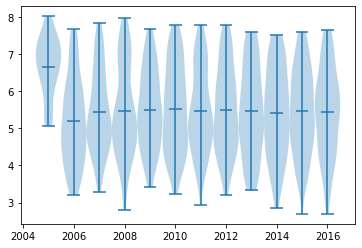

In [172]:
#Firstly, we will see if happiness has changed over time.
ipc_code = "EG.CFT.ACCS.ZS"
incomePerCap=getAllForIndicator(wdi_data, simplified_whr_data, ipc_code)
years=[]
for x,row in incomePerCap.iterrows():
    years.append(row.Year)
years=list(set(years))
years.sort()
print(years)
happy_per_year=[]
for yearIndex in years:
    currentYear=[]
    for x,row in incomePerCap.iterrows():
        if row.Year==yearIndex:
            currentYear.append(row['Life Ladder'])
    happy_per_year.append(currentYear)
   
plt.violinplot(happy_per_year,years,widths=1,showmeans=True)
print("Violin Plot")

We want to look at the data in general, correlations are cool

In [173]:
# Overall
def getAllIndicators(df, hi):
    
    mean_data = df.dropna(axis=0, thresh=5).fillna(axis=0, method='bfill').groupby(by='Indicator Code').mean().transpose() # talk about change from fillna(0) to bfill
    mean_data = mean_data.rename_axis('index', axis='columns')
    mean_data = mean_data.reset_index(level=[0]).rename(columns={'index': 'Year'})
    mean_data = mean_data.astype({'Year': np.int64})

    mean_happiness_data = hi.groupby(by='Year').mean().reset_index(level=[0])

    return mean_data.merge(mean_happiness_data, how='inner', on=['Year'])

print(getAllIndicators(wdi_data, simplified_whr_data).iloc[:,:4])

    Year  AG.AGR.TRAC.NO  AG.CON.FERT.PT.ZS  AG.CON.FERT.ZS
0   2005   251457.119245       1.484809e+03    2.823145e+02
1   2006   197358.215923       1.266296e+03    3.097155e+02
2   2007   163621.078574       1.457692e+03    2.746442e+02
3   2008    68444.614357       1.085124e+03    3.008969e+02
4   2009    60114.385301       1.016698e+03    1.766156e+02
5   2010        2.556754       4.004918e+02    1.898537e+02
6   2011        2.691892       4.697430e+02    2.271550e+02
7   2012        3.471752       4.641427e+02    2.172395e+02
8   2013        3.618624       4.086468e+02    2.220963e+02
9   2014        3.584634       5.271770e+02    2.006468e+02
10  2015        4.084381       8.148199e+02    1.913728e+02
11  2016       87.952085       8.511047e+02    1.862497e+02
12  2017       87.643229       5.409906e+02    1.863403e+02
13  2018        3.617938       5.271041e+02    1.902556e+02
14  2019        4.112503       7.242320e+07    2.051367e+08
15  2020       32.330452       1.190008e

In [174]:
# Correlation for a specific year



def getAllIndicatorsPerCountryForYear(df, hi, year):
    
    mean_data = df[["Country Name", "Indicator Name", "Indicator Code", str(year)]].fillna(0)
    new_data_table = mean_data.pivot(index=['Indicator Name'],columns=['Country Name'], values=[str(year)]).T.dropna(axis=0, thresh=5).fillna(axis=0, method='bfill')
    mean_happiness_data = hi[hi['Year'] == year]

    return new_data_table.merge(mean_happiness_data, how='inner', on=['Country Name'])

# Plotting a heatmap
corr_data_2016 = getAllIndicatorsPerCountryForYear(wdi_data, simplified_whr_data, 2016).corr()
hi_idx = corr_data_2016.columns.get_loc('Life Ladder')
# sns.heatmap(new_corr.sort_values(by='Life Ladder', ascending=False).iloc[0:len(new_corr):10, hi_idx:hi_idx+1], center = 0, cmap = 'coolwarm')

def plotYearlyHeatmap(wdi_data, hi, year):
    corr_data = getAllIndicatorsPerCountryForYear(wdi_data, hi, year).corr()
    hi_idx = corr_data.columns.get_loc('Life Ladder')
    plt.figure(figsize =(1,20))
    plt.title('World Bank Indicators Correlation with Happiness Score for {} across all countries'.format(year), fontsize =15)
    sns.heatmap(new_corr.sort_values(by='Life Ladder', ascending=False).iloc[0:len(new_corr):10, hi_idx:hi_idx+1], center = 0, cmap = 'coolwarm')
    plt.show()

# plot a 4 year period
plotYearlyHeatmap(wdi_data, simplified_whr_data, 2016)
plotYearlyHeatmap(wdi_data, simplified_whr_data, 2017)



NameError: name 'new_corr' is not defined

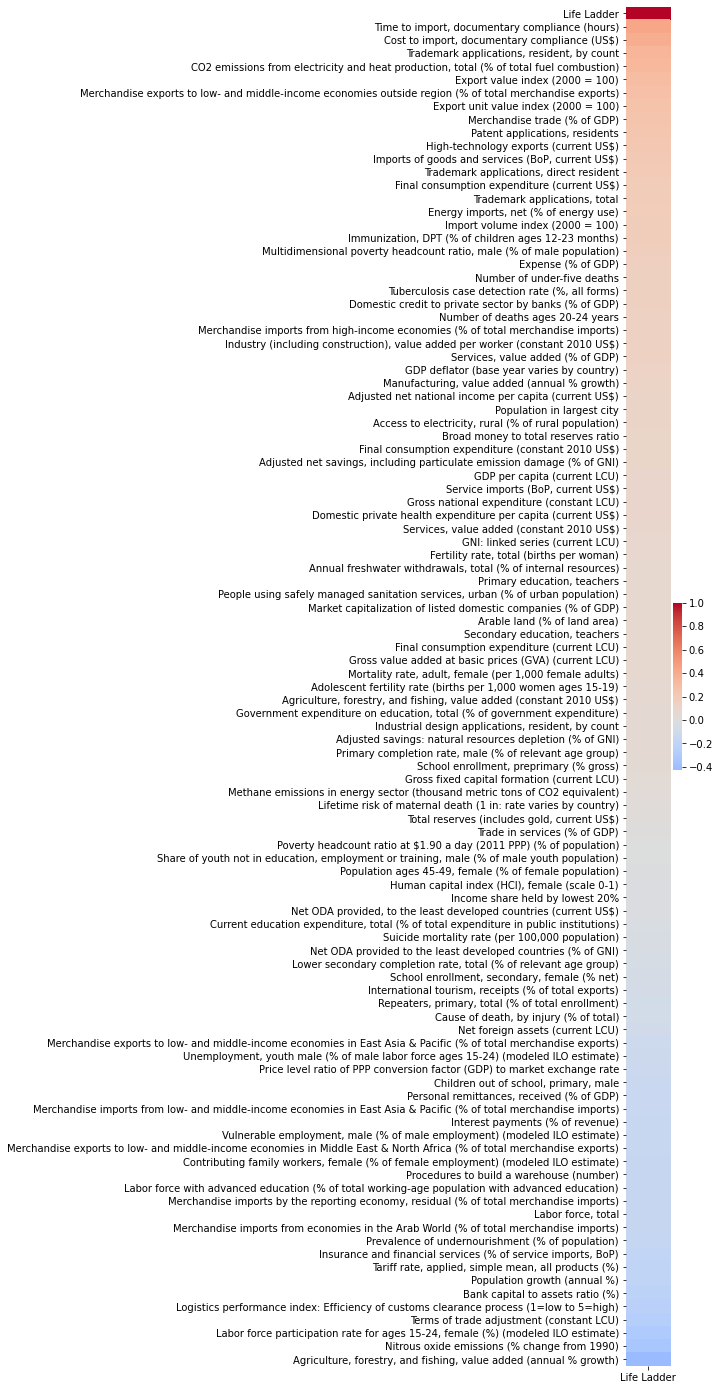

In [92]:
# For a specific country

plt.figure(figsize =(1,25))

def getAllIndicatorsForCountry(df, hi, country):

    mean_data = df[df['Country Name'] == country].dropna(axis=0, thresh=5).fillna(axis=0, method='bfill').groupby(by='Indicator Name').mean().transpose()
    mean_data = mean_data.rename_axis('index', axis='columns')
    mean_data = mean_data.reset_index(level=[0]).rename(columns={'index': 'Year'})
    mean_data = mean_data.astype({'Year': np.int64})

    return mean_data.merge(hi[hi['Country Name'] == country].groupby(by='Year').mean(), how='inner', on=['Year'])

indicator_data = getAllIndicatorsForCountry(wdi_data, simplified_whr_data, 'Sweden')
corr_data = indicator_data.corr()

hi_idx = corr_data.columns.get_loc('Life Ladder')
sns.heatmap(corr_data.sort_values(by='Life Ladder', ascending=False).iloc[0:len(corr_data):10, hi_idx:hi_idx+1], center = 0, cmap = 'coolwarm')

In [96]:
# Taking the some of the top 3
corr_data = getAllIndicatorsPerCountryForYear(wdi_data, simplified_whr_data, 2016).corr()
hi_idx = corr_data.columns.get_loc('Life Ladder')
corr_data.sort_values(by='Life Ladder', ascending=False).iloc[0:30, hi_idx:hi_idx+1]

,Life Ladder
Life Ladder,1.000000
"Life expectancy at birth, male (years)",0.802502
"Life expectancy at birth, total (years)",0.798338
"Life expectancy at birth, female (years)",0.784476
"GNI per capita, PPP (current international $)",0.773371
"Survival to age 65, male (% of cohort)",0.768846
Employment in services (% of total employment) (modeled ILO estimate),0.765822
Access to clean fuels and technologies for cooking (% of population),0.759711
Individuals using the Internet (% of population),0.758118
"Survival to age 65, female (% of cohort)",0.750665


### Some standout factors correlating with increased happiness
- Life expectancy at birth, for men and women
- Countries with higher GNI (Gross National Income per capita)
- Employment in a service based economy

In [97]:
corr_data = getAllIndicatorsPerCountryForYear(wdi_data, simplified_whr_data, 2016).corr()
hi_idx = corr_data.columns.get_loc('Life Ladder')
corr_data.sort_values(by='Life Ladder', ascending=True).iloc[0:30, hi_idx:hi_idx+1]

,Life Ladder
Employment in agriculture (% of total employment) (modeled ILO estimate),-0.768773
"Employment in agriculture, male (% of male employment) (modeled ILO estimate)",-0.757722
Prevalence of anemia among children (% of children under 5),-0.751203
"Vulnerable employment, total (% of total employment) (modeled ILO estimate)",-0.743516
"Employment in agriculture, female (% of female employment) (modeled ILO estimate)",-0.736223
"Vulnerable employment, female (% of female employment) (modeled ILO estimate)",-0.734160
"Self-employed, total (% of total employment) (modeled ILO estimate)",-0.733061
"Vulnerable employment, male (% of male employment) (modeled ILO estimate)",-0.731811
"Self-employed, female (% of female employment) (modeled ILO estimate)",-0.728033
"Mortality rate, neonatal (per 1,000 live births)",-0.725100


### Some Standout factors for negatively correlating with happiness
- % of total employment in agriculture
    - This is interesting, most likely related to how in developing countries a larger % of the population works in the farming industry,
    a lot of the mortality rates described would also corrlate
- % of total employment that is vulnerable or self-employed
- Higher mortality rates for diseases/conditions/age groups.

 
-0.03756 x + 6.462


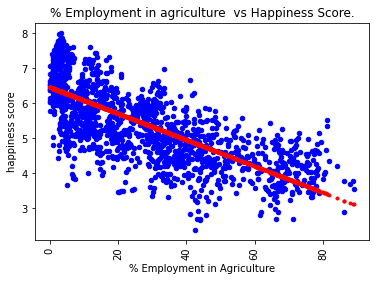

In [160]:
eia_code = "SL.AGR.EMPL.ZS"
employmentInAgriculture=getAllForIndicator(wdi_data,simplified_whr_data, eia_code)

ax=employmentInAgriculture.plot.scatter(x='indicator_value',xlabel=r"% Employment in Agriculture",y='Life Ladder',ylabel='happiness score', rot=90,color='b',title=r'% Employment in agriculture  vs Happiness Score.')
y=employmentInAgriculture['Life Ladder']
x=employmentInAgriculture['indicator_value']
z=np.polyfit(x,y,1)
eq=np.poly1d(z)
plt.plot(x,eq(x),'.',color='red')
print(eq)


 
0.1004 x - 1.718


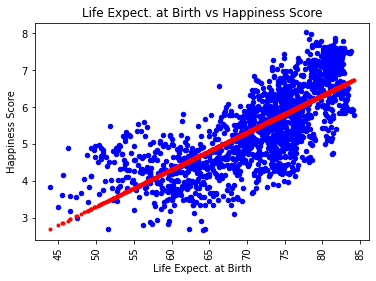

In [161]:
eia_code = "SP.DYN.LE00.IN"
employmentInAgriculture=getAllForIndicator(wdi_data,simplified_whr_data, eia_code)

ax=employmentInAgriculture.plot.scatter(x='indicator_value',xlabel='Life Expect. at Birth',y='Life Ladder',ylabel='Happiness Score', rot=90,color='b',title=r'Life Expect. at Birth vs Happiness Score')
y=employmentInAgriculture['Life Ladder']
x=employmentInAgriculture['indicator_value']
z=np.polyfit(x,y,1)
eq=np.poly1d(z)
plt.plot(x,eq(x),'.',color='red')
print(eq)

35.9251026035469


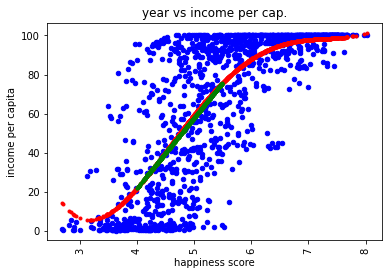

In [175]:
#When one thinks of happiness they think of money. Lets first graph the WHR dataset's graph of national income per capita vs happiness

ax=incomePerCap.plot.scatter(x='Life Ladder',xlabel='happiness score',y='indicator_value',ylabel='income per capita', rot=90,color='b',title='year vs income per cap.')
x=incomePerCap['Life Ladder']
y=incomePerCap['indicator_value']
z=np.polyfit(x,y,4)
eq=np.poly1d(z)
plt.plot(x,eq(x),'.',color='red')

x1=4
x2=5.5
y1=eq(4)
y2=eq(5.5)
slope=(y2-y1)/(x2-x1)

x=x[x>=4]
x=x[x<=5.5]
plt.plot(x,x*slope+(y1-slope*x1),'.',color='green')
print(slope)